In [14]:
import argparse
import sys
import os
from skimage import io

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.patches as mpatches


# from scheduler import CycleScheduler
from pt_utils import  Embeddings, Trainer, VQVAE, data_sampler, Vqvae2Adaptive
from torch.utils import data
from torch import distributed as dist

from umap import UMAP
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from collections import Counter
from skimage import transform, metrics
import skimage
import pandas as pd
import numpy as np
import glob

from torchsummary import summary

from tqdm.notebook import trange, tqdm
import torchvision
from PIL import Image

import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import scipy as sp
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import joblib
import pickle

seed = 51
np.random.seed(seed)
torch.manual_seed(seed)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_6112\112630579.py:37: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [96]:
# dataset_path = '../datasets/bc_right_sub_left_minmax_4x_360'
# dataset_path = '../datasets/bc_left_sub_right_0.5_4x_360'
# dataset_path = '../datasets/bc_right_sub_left_0.5_4x_360'
# dataset_path = '../datasets/bc_left_sub_right_minmax_4x_360'
# dataset_path = '../datasets/bc_left_4x_360'
# dataset_path = '../../datasets/original/o_bc_left_4x_768_360/'
# dataset_path = '../../datasets/imagenet_2_ant_camel/'
dataset_path = '../../datasets/original/o_bc_left_4x_768_360_median/'

resize_shape = (512, 512)
# resize_shape = (256, 256)

val_split=0.15
batch_size=8

transform = transforms.Compose(
    [
        # transforms.Resize(resize_shape),
        transforms.CenterCrop(resize_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

dataset = datasets.ImageFolder(dataset_path, transform=transform)

train_dataset_len = int(len(dataset) * (1 - val_split))
test_dataset_len = len(dataset) - train_dataset_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_len, test_dataset_len],
                                                            # generator=torch.Generator().manual_seed(seed)
                                                           )

train_sampler = data_sampler(train_dataset, shuffle=True, distributed=False)
test_sampler = data_sampler(test_dataset, shuffle=True, distributed=False)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, sampler=test_sampler, num_workers=2
)

In [95]:
# model_file = 'runs/emb_dim_2_n_embed_512_bc_left_4x_768_360/vqvae_012_train_0.0177_test_0.01751.pt'
# model_file = 'runs/emb_dim_1_n_embed_512_bc_left_4x_768_360/vqvae_008_train_0.01965_test_0.02003.pt'
# model_file = 'runs/emb_dim_1_n_embed_512_bc_left_4x_768_360/vqvae_002_train_0.02063_test_0.02073.pt'
# model_file = 'runs/emb_dim_1_n_embed_256_bc_left_4x_768_360/vqvae_005_train_0.0199_test_0.01966.pt'
# model_file = 'runs/emb_dim_8_n_embed_256_bc_left_4x_768_360/vqvae_003_train_0.021_test_0.02086.pt'
# model_file = 'runs/emb_dim_2_n_embed_256_bc_left_4x_768_360/vqvae_002_train_0.02079_test_0.01971.pt'
# model_file = 'runs/emb_dim_1_n_embed_128_bc_left_4x_768_360/vqvae_003_train_0.02029_test_0.0204.pt'
# model_file = 'runs/emb_dim_1_n_embed_256_ants_camels/vqvae_010_train_0.02879_test_0.02906.pt'
# model_file = 'runs/emb_dim_1_n_embed_256_o_bc_left_4x_768_360_median_otsu/vqvae_003_train_0.01315_test_0.01208.pt'
model_file='runs/emb_dim_1_n_embed_256_o_bc_left_4x_768_360_median/vqvae_005_train_0.00049_test_0.00047.pt'

device = "cuda"

model =    VQVAE(
                in_channel=3,
                channel=128,
                n_res_block=2,
                n_res_channel=32,
                embed_dim=1,
                n_embed=256,
                decay=0.99
                   ).to(device)

model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [97]:
original_imgs=[]
images_embs_t = []
images_embs_b = []
indices_t=[]
indices_b=[]
labels=[]

n=0
N=200

with torch.no_grad():
    for batch in tqdm(train_loader):
        if n<N/batch_size:
            batch_tensor=torch.FloatTensor(batch[0]).to(device)
            quant_t, quant_b, diff, ind_t, ind_b = model.encode(batch_tensor)

            original_imgs.extend(batch_tensor.cpu().detach().numpy())
            images_embs_t.extend(quant_t.cpu().detach().numpy())
            images_embs_b.extend(quant_b.cpu().detach().numpy())
            indices_t.extend(ind_t.cpu().detach().numpy())
            indices_b.extend(ind_b.cpu().detach().numpy())
            labels.extend(batch[1].cpu().detach().numpy())
            n+=1



original_imgs=np.array(original_imgs)
images_embs_t=np.array(images_embs_t)
images_embs_b=np.array(images_embs_b)
indices_t=np.array(indices_t)
indices_b=np.array(indices_b)
labels=np.array(labels)

print(images_embs_t.shape)
print(images_embs_b.shape)

  0%|          | 0/765 [00:00<?, ?it/s]

(200, 1, 64, 64)
(200, 1, 128, 128)


In [98]:
original_imgs_sorted=[]
images_embs_t_sorted=[]
images_embs_b_sorted=[]
indices_t_sorted=[]
indices_b_sorted=[]

for i,value in enumerate(np.unique(labels)):
    indices=np.where(labels==value)
    original_imgs_sorted.append([])
    images_embs_t_sorted.append([])
    images_embs_b_sorted.append([])
    indices_t_sorted.append([])
    indices_b_sorted.append([])
    
    original_imgs_sorted[i].extend(original_imgs[indices])
    images_embs_t_sorted[i].extend(images_embs_t[indices])
    images_embs_b_sorted[i].extend(images_embs_b[indices])
    indices_t_sorted[i].extend(indices_t[indices])
    indices_b_sorted[i].extend(indices_b[indices])

In [6]:
def convert_img(out):
    utils.save_image(
        out,
        f"test1.png",
        nrow=4,
        normalize=True,
        )
    img=io.imread('test1.png')
    os.remove('test1.png')
    return img

In [ ]:
plt.hist(img.flatten(), bins=50)

In [ ]:
plt.hist(quant_t.cpu().detach().numpy().flatten(), bins=50)
plt.show()

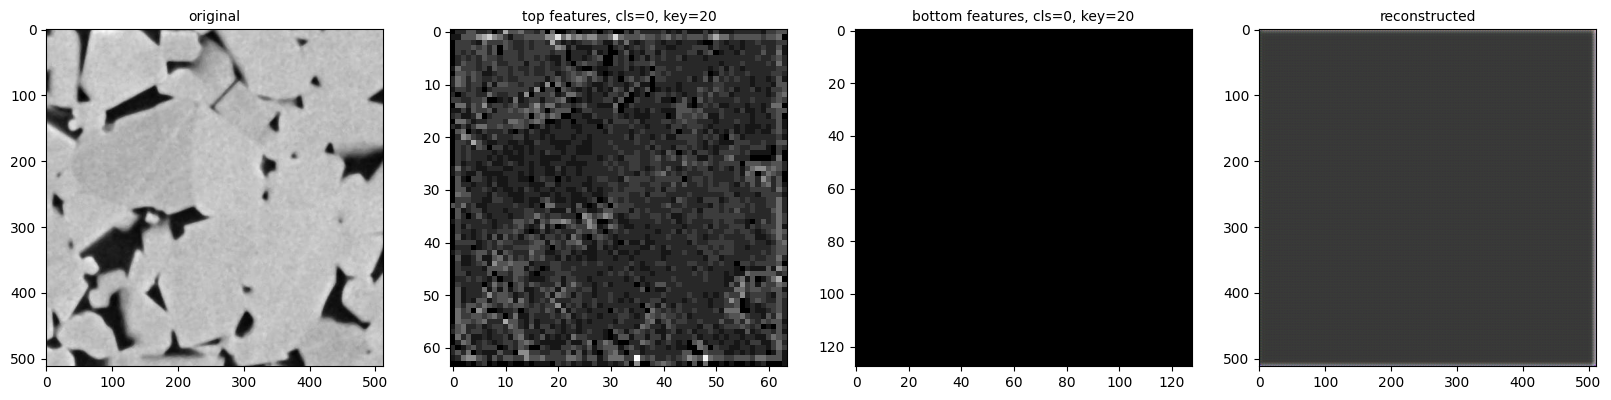

In [101]:
sorted_indices=np.argsort(labels)

sorted_labels=labels[sorted_indices]
indices=[np.where(sorted_labels==i) for i in range(5)]

cls_1=0
key_1=20

cls_2=0
key_2=20

quant_t_=images_embs_t_sorted[cls_1][key_1]
# quant_t_=np.random.normal(0,0, 64*64).reshape((1,64,64))
# quant_t_=np.random.normal(0,0, 32*32).reshape((1,32,32))
# quant_t_=np.random.geometric(0.2,64*64).reshape((1,64,64))


# quant_b_=images_embs_b_sorted[cls_2][key_2]
quant_b_=np.random.normal(0,0, 128*128).reshape((1,128,128))
# quant_b_=np.random.normal(0,0, 64*64).reshape((1,64,64))

quant_t=torch.FloatTensor(quant_t_).to(device)
quant_b=torch.FloatTensor(quant_b_).to(device)

quant_t=torch.unsqueeze(quant_t, dim=0)
quant_b=torch.unsqueeze(quant_b, dim=0)

with torch.no_grad():
    img=model.decode(quant_t, quant_b)

img=convert_img(img)
original_1=original_imgs_sorted[cls_1][key_1]
original=convert_img(torch.FloatTensor(original_1))

fig, axes=plt.subplots(1,4, figsize=(20,10))


axes[0].imshow(original)
axes[0].set_title(f'original', fontsize=10)

# axes[1].imshow(indices_t_sorted[cls_1,key_1].swapaxes(0,-1))
axes[1].imshow(np.flip(np.rot90(quant_t_.swapaxes(0,-1),-1),1), cmap='gray')
axes[1].set_title(f'top features, cls={cls_1}, key={key_1}', fontsize=10)

# axes[2].imshow(indices_b_sorted[cls_2,key_2].swapaxes(0,-1), )
axes[2].imshow(np.flip(np.rot90(quant_b_.swapaxes(0,-1),-1),1), cmap='gray')
axes[2].set_title(f'bottom features, cls={cls_2}, key={key_2}', fontsize=10)

axes[3].imshow(img)
axes[3].set_title('reconstructed', fontsize=10)
plt.show()

In [9]:
original

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [10]:
img

array([[[145, 165, 139],
        [180, 185, 196],
        [170, 183, 186],
        ...,
        [198, 168, 183],
        [199, 198, 187],
        [157, 161, 163]],

       [[196, 180, 185],
        [180, 201, 205],
        [203, 209, 189],
        ...,
        [207, 193, 189],
        [204, 197, 205],
        [180, 191, 178]],

       [[191, 184, 188],
        [208, 194, 208],
        [212, 203, 201],
        ...,
        [192, 197, 187],
        [198, 218, 196],
        [186, 171, 178]],

       ...,

       [[185, 209, 189],
        [218, 210, 190],
        [196, 217, 196],
        ...,
        [214, 214, 183],
        [196, 182, 211],
        [199, 185, 186]],

       [[184, 197, 187],
        [194, 219, 193],
        [198, 215, 199],
        ...,
        [184, 195, 196],
        [193, 184, 185],
        [179, 191, 184]],

       [[136, 157, 143],
        [194, 182, 184],
        [167, 198, 177],
        ...,
        [210, 185, 175],
        [201, 193, 199],
        [183, 155, 142]]

## 1. $C^1_{top}$ + $C^2_{bottom}$

## 2. $C^1_{top/bottom}$ + random

## 2. $C^1_{top}$ + sampling